<a href="https://colab.research.google.com/github/Kaffos/MAGS_Simulation/blob/main/simsim_completed_filled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
## Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/MAGS_Sim/'

## Data loading

def load_fligth_data(file_path):
  data = pd.read_csv(file_path)
  return data

def preprocess_flight_data(df, time_col='Time', altitude_col='Altitude', velocity_col='Velocity'):
  if df is not None:
    df = df[[time_col, altitude_col, velocity_col]].copy()
    df.rename(columns={time_col: 'Time', altitude_col: 'Altitude', velocity_col: 'Velocity'}, inplace=True)
    return df


## Simulate parabola
def simulate_parabolic_trajectory(df, G, horizontal_distance=2000):
  peak_altitude = df['Altitude'].max()
  v_y_initial = math.sqrt(2 * G * peak_altitude)
  t_peak = v_y_initial / G
  t_flight = 2 * t_peak

  # Assuming constant horizontal velocity
  horizontal_velocity = horizontal_distance / t_flight

  # Calculate positions at each timestamp
  df['Horizontal_Distance'] = df['Time'].apply(
      lambda t: horizontal_velocity * t if t <= t_flight else horizontal_distance
  )

  return df


## Antenna Mount

def mount_kinetics(time, altitude, dist):
  time = np.asarray(time, dtype=float)
  altitude = np.asarray(altitude, dtype=float)

  theta_rad = np.arctan2(altitude, dist)
  theta_deg = np.degrees(theta_rad)

  omega_rad = np.gradient(theta_rad, time)
  omega_deg = np.degrees(omega_rad)

  alpha_rad = np.gradient(omega_rad, time)
  alpha_deg = np.degrees(alpha_rad)

  df = pd.DataFrame({'Time': time, 'Elevation': theta_deg, 'Angular vel': omega_deg, 'Angular acc': alpha_deg, 'theta_rad': theta_rad, 'omega_rad': omega_rad, 'alpha_rad': alpha_rad})

  return df


## Motors

def torque_needed(df, length, mass, G):
  inertia = 1/3 * mass * length**2 #kg.m^2

  df['Torque_el'] = df.apply(lambda row: row['alpha_rad'] * inertia + mass * G * length / 2 * math.cos(row['theta_rad']), axis = 1)
  df['Power_el'] = df.apply(lambda row: row['Torque_el'] * row['omega_rad'], axis = 1)

  return df



#Channel Modulation

# def fspl_db(distance_m, freq_hz):
#     """Free-space path loss (dB)."""
#     if distance_m <= 0:
#         return 0.0
#     c = 299792458.0
#     lam = c / freq_hz
#     return 20 * math.log10(4 * math.pi * distance_m / lam)



# Geometry helpers
def slant_range(horizontal_sep_m, rocket_altitude_m, mount_height_m=0.0):
    """
    Compute slant range between mount and rocket in 2D (x-z).
    horizontal_sep_m: constant (or array) horizontal separation (m)
    rocket_altitude_m: array-like altitude of rocket (m)
    mount_height_m: mount elevation above ground (m)
    """
    dz = np.asarray(rocket_altitude_m, dtype=float) - float(mount_height_m)
    dx = np.asarray(horizontal_sep_m, dtype=float)
    return np.sqrt(dx**2 + dz**2)

def elevation_angle_deg(horizontal_sep_m, rocket_altitude_m, mount_height_m=0.0):
    dz = np.asarray(rocket_altitude_m, dtype=float) - float(mount_height_m)
    dx = np.asarray(horizontal_sep_m, dtype=float)
    return np.degrees(np.arctan2(dz, dx))


# RF link budget
def fspl_db(distance_m, freq_hz):
    """Free-space path loss (dB)."""
    if np.any(np.asarray(distance_m) <= 0):
        # Protect log, return very small distance fspl for zeros
        distance_m = np.maximum(np.asarray(distance_m, dtype=float), 1e-6)
    c = 299792458.0
    lam = c / float(freq_hz)
    return 20.0 * np.log10(4.0 * math.pi * np.asarray(distance_m) / lam)

def received_power_dbm(P_tx_dbm, G_tx_dbi, G_rx_dbi, fspl_db_val, extra_losses_db=0.0):
    """
    Friis link: Prx(dBm) = Ptx + Gtx + Grx - FSPL - losses
    All scalars or arrays broadcastable to time length.
    """
    return (float(P_tx_dbm) + float(G_tx_dbi) + float(G_rx_dbi)
            - np.asarray(fspl_db_val, dtype=float) - float(extra_losses_db))

def noise_power_dbm(B_Hz, NF_dB=0.0):
    """
    Thermal noise: N0 = -174 dBm/Hz at 290K
    N = N0 + 10log10(B) + NF
    """
    return -174.0 + 10.0 * np.log10(float(B_Hz)) + float(NF_dB)

def snr_db(P_rx_dbm, N_dbm):
    return np.asarray(P_rx_dbm, dtype=float) - float(N_dbm)

def compute_link_over_time(time_s, altitude_m, horiz_sep_m, mount_height_m,
                           freq_hz, P_tx_dbm, G_tx_dbi, G_rx_dbi, losses_db,
                           bandwidth_hz, noise_figure_db):
    """
    Returns a DataFrame with time, range, FSPL, Prx, N, SNR.
    """
    time = np.asarray(time_s, dtype=float)
    alt = np.asarray(altitude_m, dtype=float)
    R = slant_range(horiz_sep_m, alt, mount_height_m)
    FSPL = fspl_db(R, freq_hz)
    Prx = received_power_dbm(P_tx_dbm, G_tx_dbi, G_rx_dbi, FSPL, losses_db)
    N = noise_power_dbm(bandwidth_hz, noise_figure_db)
    SNR = snr_db(Prx, N)
    out = pd.DataFrame({
        "Time": time,
        "Range_m": R,
        "FSPL_dB": FSPL,
        "Prx_dBm": Prx,
        "Noise_dBm": N,
        "SNR_dB": SNR
    })
    return out




## Visualization

def plot_flight_position(df):
  plt.figure(figsize=(10, 6))
  plt.plot(df['Time'], df['Altitude'], label='10k')
  plt.plot(df['Time'], df['Horizontal_Distance'], label='Horizontal_Distance')
  plt.xlabel('Time (s)')
  plt.ylabel('Altitude/distance (m)')
  plt.title('Flight Data')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_kinetics(df):
  plt.figure(figsize=(10, 6))
  plt.plot(df['Time'], df['Elevation'], color='tab:blue', label='Elevation (deg)')
  plt.plot(df['Time'], df['Angular vel'], color='tab:orange', label='Angular velocity (deg/s)')
  plt.xlabel('Time (s)')
  plt.ylabel('Angle (deg)')
  plt.title('Kinetics')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_torque(df):
  plt.figure(figsize=(10, 6))
  plt.plot(df['Time'], df['Torque_el'], color='tab:blue', label='Torque (N.m)')
  plt.plot(df['Time'], df['Power_el'], color='tab:orange', label='Power (W)')
  plt.xlabel('Time (s)')
  plt.ylabel('Torque/Power (N.m, W)')
  plt.title('Torque')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_link_power_snr(df_link):
    plt.figure(figsize=(10,6))
    plt.plot(df_link["Time"], df_link["Prx_dBm"], label="Received Power (dBm)")
    plt.plot(df_link["Time"], df_link["SNR_dB"], label="SNR (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("dB / dBm")
    plt.title("Received Power & SNR vs Time")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_range_fspl(df_link):
    plt.figure(figsize=(10,6))
    plt.plot(df_link["Time"], df_link["Range_m"], label="Slant Range (m)")
    plt.plot(df_link["Time"], df_link["FSPL_dB"], label="FSPL (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Range (m) / FSPL (dB)")
    plt.title("Range & FSPL vs Time")
    plt.grid(True)
    plt.legend()
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Main

        Time    Altitude   Velocity
0       0.00    0.000043   0.000000
1       0.05    8.519119   8.095238
2       0.10   17.042070  16.190480
3       0.15   22.722930  21.619050
4       0.20   28.406460  27.047620
...      ...         ...        ...
3089  154.45 -220.755600   0.000000
3090  154.50 -220.755600   0.000000
3091  154.55 -220.755600   0.000000
3092  154.60 -220.755600  -2.666667
3093  154.65 -220.755600   0.000000

[3094 rows x 3 columns]


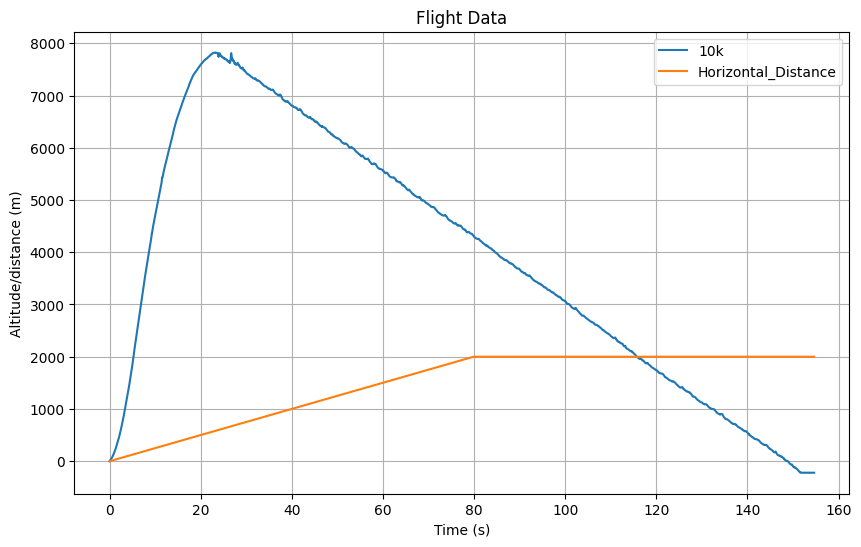

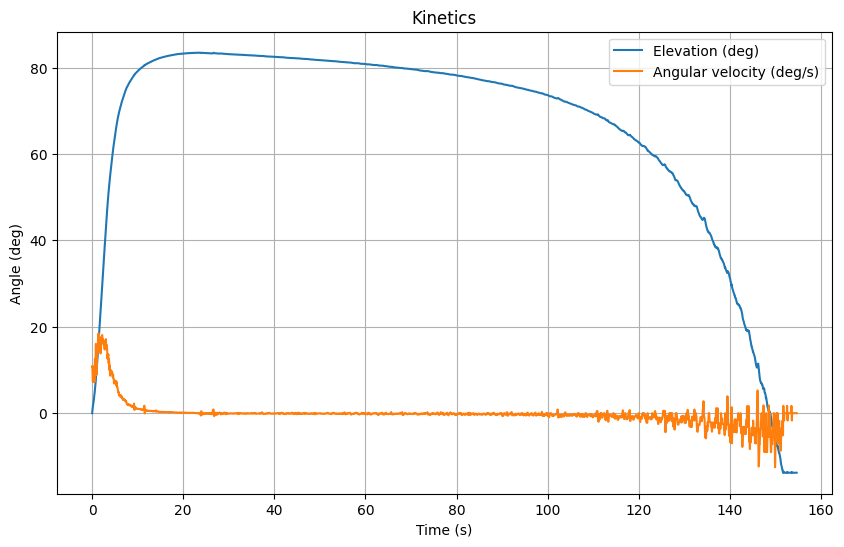

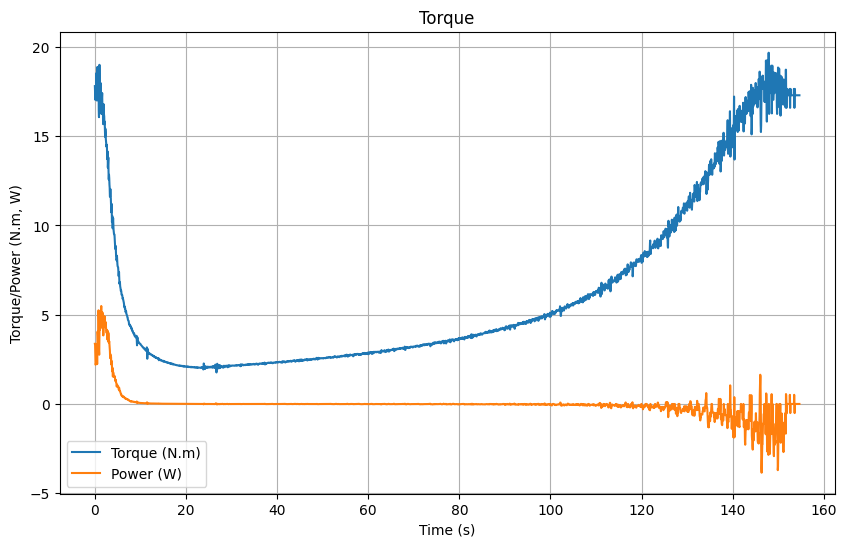

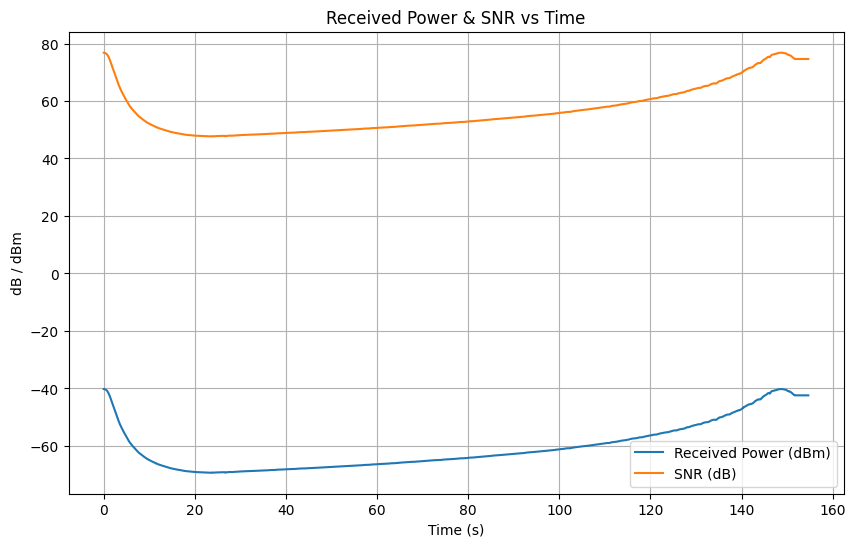

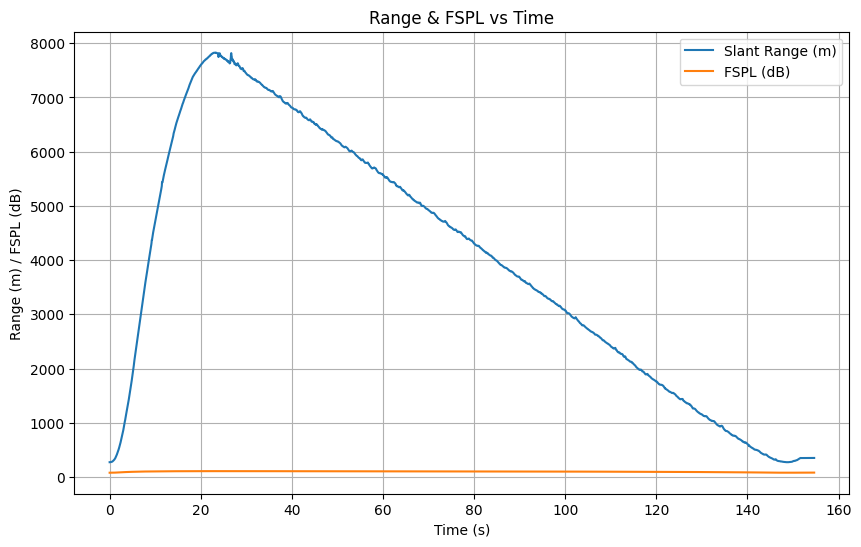

In [12]:
def main():
  #Setup
  DIST_TO_PAD = 900 #ft
  FT_TO_M = 0.3048
  DIST_TO_PAD_M = DIST_TO_PAD * FT_TO_M
  LENGTH = 1 #m
  MASS = 3.63 #kg
  G = 9.81 #m.s^-2
  G_RX_DBI = 11.1       # Yagi (given)
  MOUNT_HEIGHT_M  = 1.0        # mount at 1 m above ground

  FREQ_HZ         = 903e6      # 900 MHz center
  P_TX_DBM        = 27.0       # ~0.5 W typical
  G_TX_DBI        = 2.0        # small monopole/whip
  EXTRA_LOSSES_DB = 0.0        # implement but default to 0 as requested
  BANDWIDTH_HZ    = 250e3      # 250 kHz nominal telemetry bandwidth
  NOISE_FIGURE_DB = 3.0        # typical good receiver NF


  raw_data = load_fligth_data(path + 'MRT Porthos official Flight data 2023.csv')
  mags = preprocess_flight_data(raw_data)
  print(mags)
  simulated_trajectory_df = simulate_parabolic_trajectory(mags, G)

  plot_flight_position(mags)

  #Mount
  kinetics = mount_kinetics(mags['Time'], mags['Altitude'], DIST_TO_PAD)
  plot_kinetics(kinetics)


  torque = torque_needed(kinetics, LENGTH, MASS, G)
  plot_torque(torque)

  link = compute_link_over_time(
      time_s=mags['Time'].values,
      altitude_m=mags['Altitude'].values,
      horiz_sep_m=DIST_TO_PAD_M,
      mount_height_m=MOUNT_HEIGHT_M,
      freq_hz=FREQ_HZ,
      P_tx_dbm=P_TX_DBM,
      G_tx_dbi=G_TX_DBI,
      G_rx_dbi=G_RX_DBI,
      losses_db=EXTRA_LOSSES_DB,
      bandwidth_hz=BANDWIDTH_HZ,
      noise_figure_db=NOISE_FIGURE_DB
  )

  plot_link_power_snr(link)
  plot_range_fspl(link)


if __name__ == '__main__':
  main()